# Time Series Analysis

by: Blaise Andrei V. Geronimo

# Imports

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
asset = "XLY"
starting_date = "2010-01-01"

data = yf.download(asset, start=starting_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
xly_df = data.Close
xly_df = xly_df.rename(columns={asset:'closing_price'})
xly_df

Ticker,closing_price
Date,
2010-01-04,24.811806
2010-01-05,24.902782
2010-01-06,24.935858
2010-01-07,25.142624
2010-01-08,25.134363
...,...
2025-05-05,199.289993
2025-05-06,197.550003
2025-05-07,199.089996


# Exploratory Data Analysis

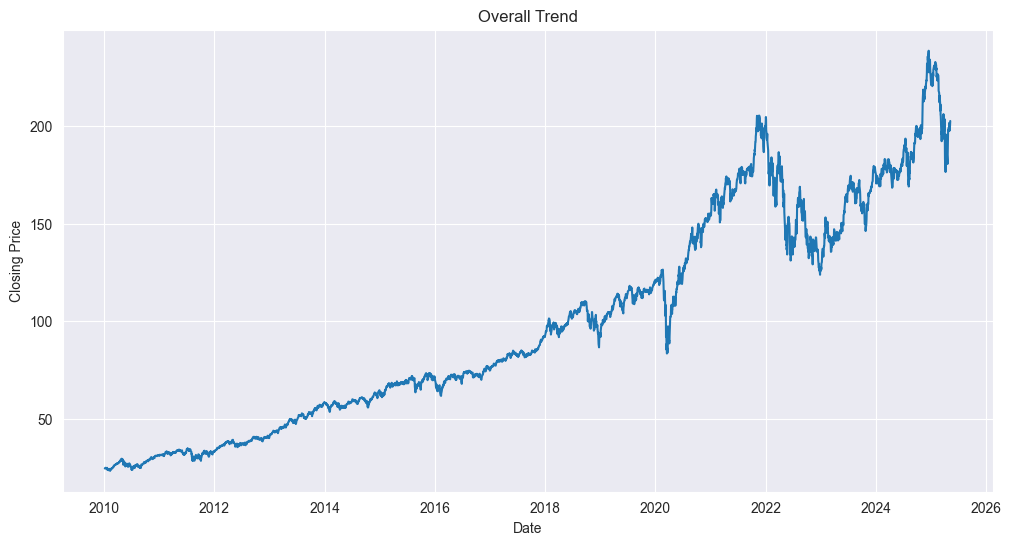

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(xly_df['closing_price'])
plt.title('Overall Trend')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

The original time series exhibits a strong long-term upward trend with noticeable volatility, particularly after 2020. Periods of sharp decline, such as during the 2020 COVID-19 crash, and rapid recoveries are evident. The increasing variance over time suggests the need for transformation (e.g., log) before applying time series models that assume stationarity.

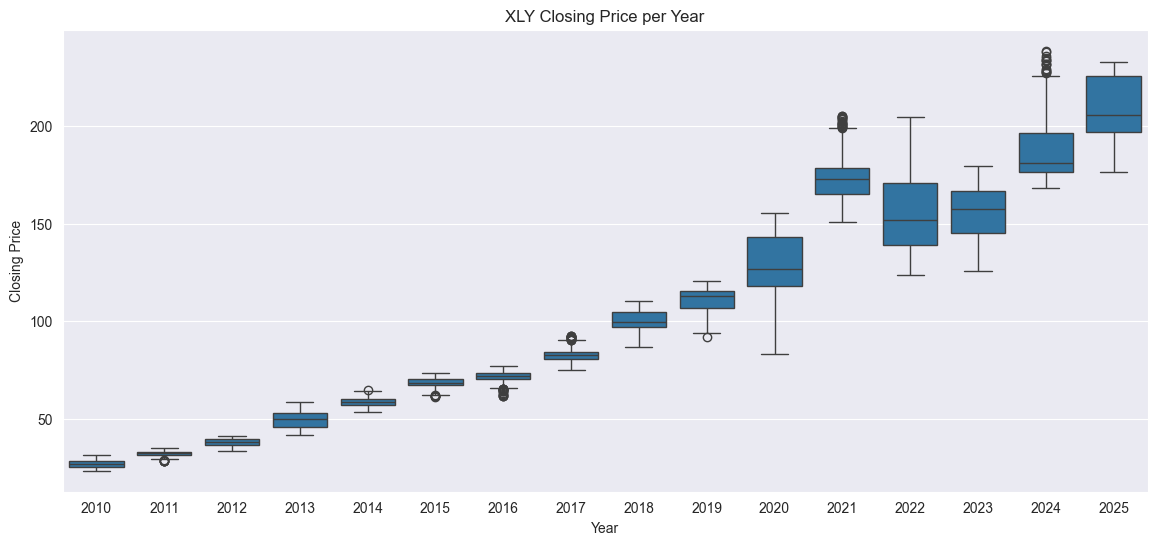

In [5]:
xly_df['year'] = xly_df.index.year

plt.figure(figsize=(14, 6))
sns.boxplot(x='year', y='closing_price', data=xly_df)
plt.title('XLY Closing Price per Year')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

This boxplot reveals a consistent upward shift in the distribution of XLY’s closing prices from 2010 to 2025, highlighting strong long-term growth. The spread and number of outliers significantly increase starting around 2020, indicating heightened volatility during and after the COVID-19 market shock. Wider interquartile ranges in recent years reflect greater uncertainty and price dispersion, justifying the need for transformation and differencing prior to modeling.

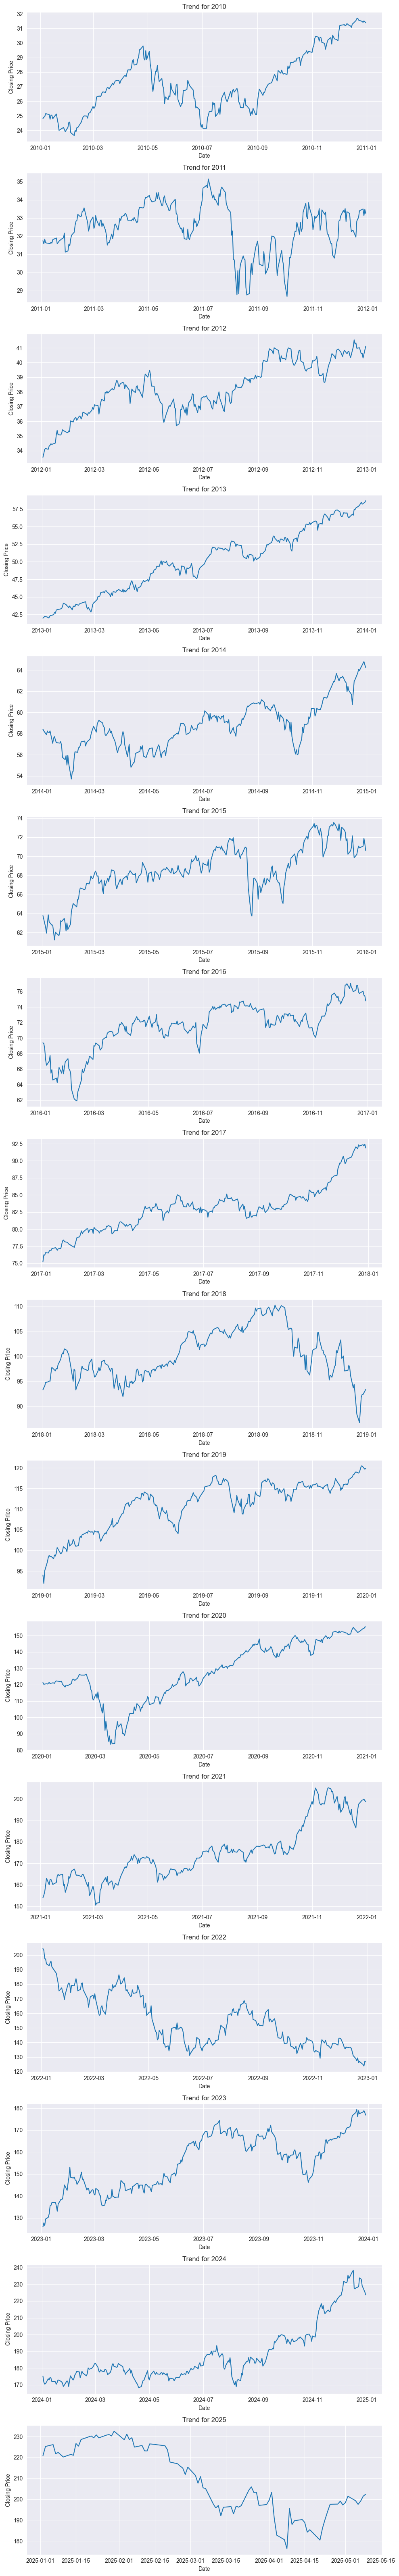

In [6]:
xly_df['year'] = xly_df.index.year
years = xly_df['year'].unique()

fig, axs = plt.subplots(len(years), 1, figsize=(10, 4 * len(years)))

for i, year in enumerate(years):
    yearly_data = xly_df[xly_df['year'] == year]
    axs[i].plot(yearly_data.index, yearly_data['closing_price'])
    axs[i].set_title(f'Trend for {year}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Closing Price')

plt.tight_layout()
plt.show()

These subplots display the intra-year closing price movements of XLY from 2010 to 2025. While several years exhibit strong upward or downward movements, such as sustained growth in 2013 and 2017, or sharp declines in 2022, there is no consistent, recurring pattern across years that would indicate clear seasonality. Each year displays unique trend shapes, perhaps driven by broader macroeconomic conditions rather than cyclical seasonal factors. This absence of regular periodic behavior reinforces the decision to exclude seasonal decomposition or seasonal ARIMA (SARIMA) models, and instead focus on trend-based transformations and differencing to achieve stationarity.

## Check Stationarity using ADF Test

In [7]:
result = adfuller(xly_df['closing_price'])

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print('Augmented Dickey-Fuller Test:')
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

if p_value < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

Augmented Dickey-Fuller Test:
ADF Statistic: -0.37623156000383196
p-value: 0.9139922579285079
Critical Values:
   1%: -3.4320545266690643
   5%: -2.8622931663475333
   10%: -2.5671709199533637
Fail to reject the null hypothesis: The series is non-stationary.


In [8]:
kpss_result = kpss(xly_df['closing_price'].dropna(), regression='c', nlags='auto')
print('KPSS Test:')
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'   {key}: {value}')
if kpss_result[1] < 0.05:
    print("Reject the null hypothesis: The series is not stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")

KPSS Test:
KPSS Statistic: 9.187161649685644
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Reject the null hypothesis: The series is not stationary.


## Flowchart for Checking and Addressing Stationarity

![image](stationarity.drawio.png)

To achieve stationarity, apply the transformation that best matches the structure of your time series:

* **Exponential Trend or Increasing Variance**: Apply a log transformation to stabilize the variance and linearize exponential growth patterns. (Fiveable, 2024)
* **Presence of Both Trend and Seasonality**: Use time series decomposition (e.g., STL or additive decomposition) to separate and remove the trend and seasonal components. (GeeksforGeeks, 2023)
* **High Frequency Noise / Short-Term Fluctuations**: Use subtracting moving average to smooth the series and reveal underlying patterns. (GeeksforGeeks, 2025)
* **No clear trend/seasonality or preprocessing fails**: Use differencing to eliminate remaining trends or seasonal cycles. If the first difference still results in non-stationarity, apply higher-order differencing as needed.

After each transformation, re-test using the ADF / KPSS test to confirm whether the series has become stationary.

For the XLY closing price data, although the variance appears to increase in later years, the trend does not follow a clearly exponential pattern. Nevertheless, applying a logarithmic transformation remains useful, not to linearize the trend, but to partially stabilize the increasing variance over time, especially in the presence of compounding percentage changes in price levels.

Since the time series does not exhibit strong or consistent seasonal patterns, as confirmed by the year-by-year visual inspection, we will not apply seasonal decomposition techniques. The lack of clear periodic behavior suggests that such methods would not contribute meaningfully to the analysis.

The series demonstrates a dominant upward trend, alongside short-term fluctuations that have become more pronounced in recent years. Subtracting a moving average is therefore appropriate to smooth out local variations and remove the long-term trend component, which is a necessary step toward achieving stationarity.

Following the log transformation and trend removal via moving average subtraction, differencing will be applied as needed to address any remaining non-stationarity. Although higher order differencing is an option, applying it will be avoided because numerous transformations have already been applied, and modeling on a higher order transformed might not capture the original behavior of the data.

# Differencing

In [9]:
xly_df

Ticker,closing_price,year
Date,,
2010-01-04,24.811806,2010
2010-01-05,24.902782,2010
2010-01-06,24.935858,2010
2010-01-07,25.142624,2010
2010-01-08,25.134363,2010
...,...,...
2025-05-05,199.289993,2025
2025-05-06,197.550003,2025
2025-05-07,199.089996,2025


In [10]:
xly_df['log_transformed_closing_price'] = np.log(xly_df['closing_price']) # log transform because of high variance at the end

In [11]:
rolling_mean = xly_df['log_transformed_closing_price'].rolling(window=252).mean()
xly_df['log_transformed_sub_ma_closing_price'] = xly_df['log_transformed_closing_price'] - rolling_mean

In [12]:
def difference(X, interval=1):
    diff = []
    for i in range(interval, len(X)):
        value = X.iloc[i] - X.iloc[i - interval]
        diff.append(value)
    return pd.Series(diff, index=X.index[interval:], dtype='float64')

In [13]:
xly_df['differenced_closing_price'] = difference(xly_df['log_transformed_sub_ma_closing_price'])

In [14]:
xly_df

Ticker,closing_price,year,log_transformed_closing_price,log_transformed_sub_ma_closing_price,differenced_closing_price
Date,,,,,
2010-01-04,24.811806,2010,3.211320,NaN,NaN
2010-01-05,24.902782,2010,3.214980,NaN,NaN
2010-01-06,24.935858,2010,3.216307,NaN,NaN
2010-01-07,25.142624,2010,3.224565,NaN,NaN
2010-01-08,25.134363,2010,3.224236,NaN,NaN
...,...,...,...,...,...
2025-05-05,199.289993,2025,5.294761,0.005430,-0.011243
2025-05-06,197.550003,2025,5.285992,-0.003816,-0.009247
2025-05-07,199.089996,2025,5.293757,0.003468,0.007284


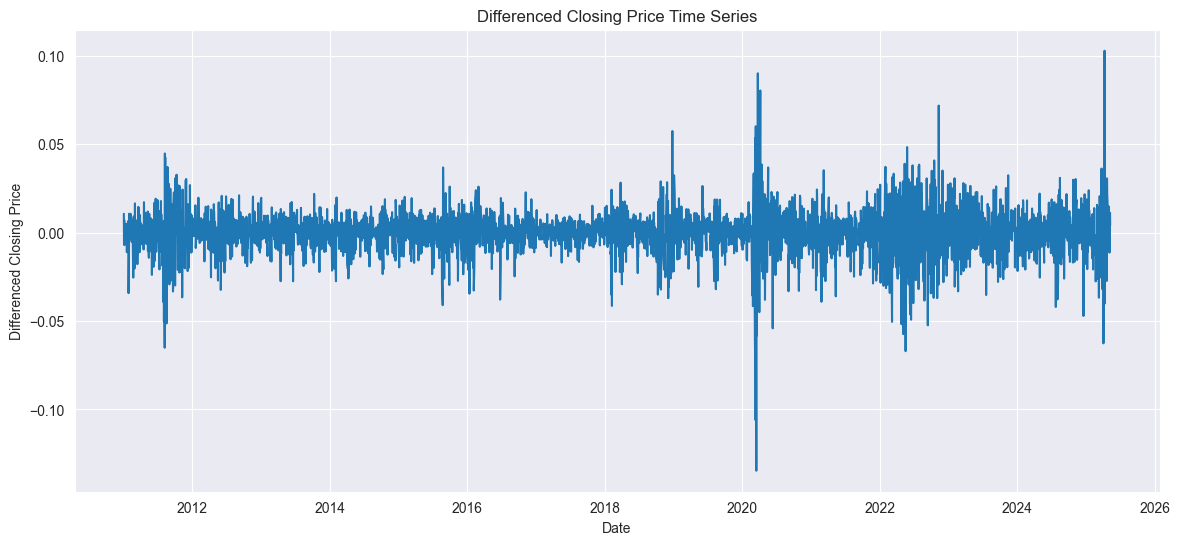

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(xly_df['differenced_closing_price'])
plt.title('Differenced Closing Price Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Closing Price')
plt.show()

This figure displays the time series of XLY closing prices after applying a log transformation, subtracting the moving average, and performing first-order differencing. The preprocessing sequence was designed to remove increasing variance, extract short-term fluctuations, and stabilize the mean to satisfy the stationarity assumptions required by ARIMA models. The resulting differenced series appears to be centered around zero, with no obvious upward or downward trend, indicating the successful removal of non-stationary components. Short bursts of volatility, particularly during market disruptions such as the 2020 COVID-19 crash and late-2024 price shocks, are visible through isolated large spikes. Importantly, the variance across the series is relatively stable over time, though there are periods with transient clustering of larger deviations. This reflects market regimes with higher uncertainty but does not invalidate stationarity for modeling purposes. Overall, the preprocessing pipeline effectively transformed the original non-stationary price series into a stationary form, making it well-suited for ARIMA modeling as confirmed by subsequent ADF and KPSS tests.

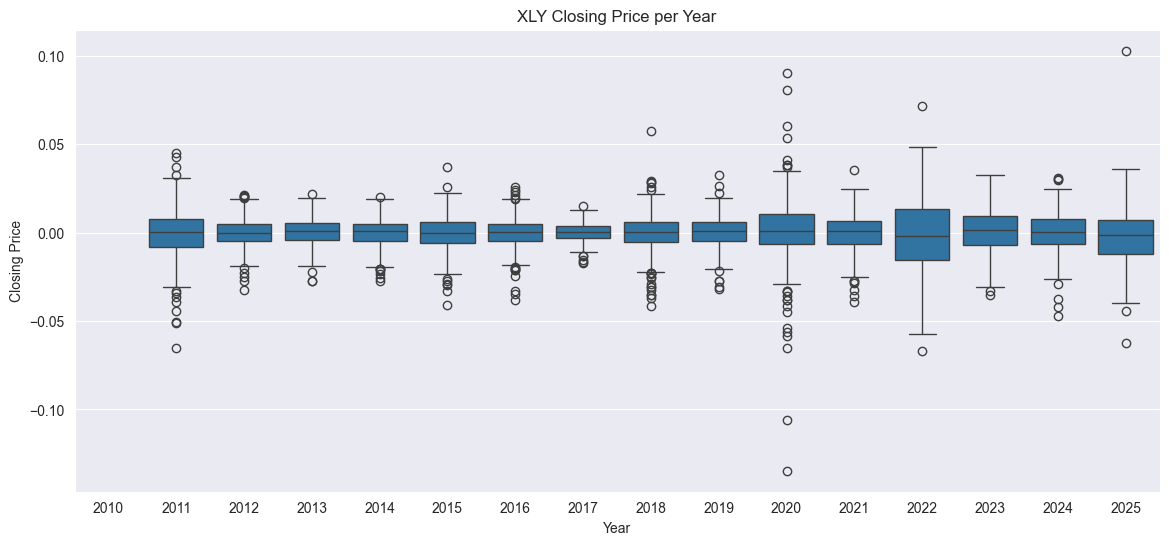

In [17]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='year', y='differenced_closing_price', data=xly_df)
plt.title('XLY Closing Price per Year')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

This boxplot displays the annual distribution of the differenced log-transformed closing prices of XLY, effectively capturing yearly return behavior from 2010 to 2025. For most years, the distributions are tightly clustered around zero, reflecting the general stability of daily returns under typical market conditions. However, certain years, particularly 2020 and 2022, exhibit noticeably wider interquartile ranges and a proliferation of extreme outliers, signaling periods of elevated volatility and potential market distress. The year 2020, perhaps influenced by the COVID-19 shock, shows both a high frequency and magnitude of extreme negative and positive returns, while 2022 features several large deviations from the median likely linked to macroeconomic uncertainty or post-pandemic corrections. The widening of boxes and whiskers in these years confirms structural shifts in return dispersion during crisis events. In contrast, years like 2014 through 2017 reflect relatively stable behavior with fewer outliers. This visualization reinforces the importance of accounting for volatility clustering and regime shifts in time series modeling, and it justifies the use of differencing to stabilize such year-to-year variation prior to ARIMA application.

# Re-Check for Stationarity

<Figure size 1200x800 with 0 Axes>

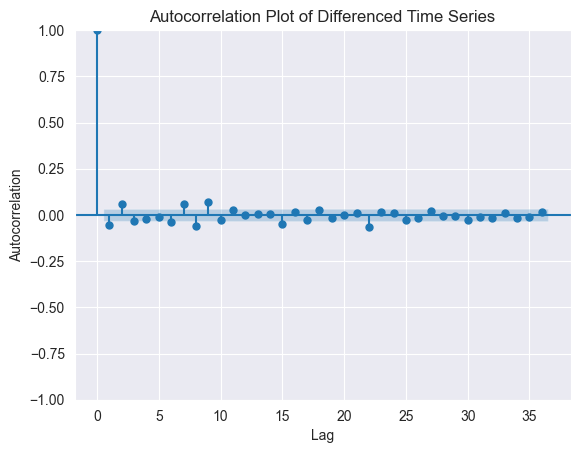

In [18]:
plt.figure(figsize=(12, 8))
plot_acf(xly_df['differenced_closing_price'].dropna())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot of Differenced Time Series')
plt.show()

This autocorrelation plot visualizes the correlation structure of the differenced log-transformed closing price series (i.e., returns) across multiple lags. The most striking feature is the strong autocorrelation at lag 1, which is expected due to the differencing process itself. Beyond this initial spike, the remaining autocorrelations fall well within the 95% confidence bounds, indicating that the series exhibits no significant serial correlation at higher lags. This pattern suggests that, after differencing, the time series behaves approximately as white noise, a hallmark of stationarity. From a modeling standpoint, this supports the effectiveness of the differencing step and implies that simple ARIMA models with low-order autoregressive (AR) and moving average (MA) components may be sufficient to capture the residual structure. However, the presence of even mild fluctuations at early lags hints that a small number of AR or MA values may further improve model fit without overfitting.

In [19]:
result = adfuller(xly_df['differenced_closing_price'].dropna())

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print('Augmented Dickey-Fuller Test:')
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

if p_value < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

Augmented Dickey-Fuller Test:
ADF Statistic: -19.89179999043005
p-value: 0.0
Critical Values:
   1%: -3.432167263984617
   5%: -2.862342965529657
   10%: -2.5671974312860577
Reject the null hypothesis: The series is stationary.


In [20]:
# KPSS Test
kpss_result = kpss(xly_df['differenced_closing_price'].dropna(), regression='c', nlags='auto')
print('KPSS Test:')
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'   {key}: {value}')
if kpss_result[1] < 0.05:
    print("Reject the null hypothesis: The series is not stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")

KPSS Test:
KPSS Statistic: 0.013873124154735315
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Fail to reject the null hypothesis: The series is stationary.


# Forecasting

In [21]:
xly_series = xly_df['log_transformed_sub_ma_closing_price'].dropna() # since ARIMA differences on its own

In [22]:
test_size = round(len(xly_series) * 0.2)
train, test = xly_series[:-test_size], xly_series[-test_size:]

[test set should be at least 20% of the total sample](https://otexts.com/fpp2/accuracy.html#:~:text=The%20size%20of%20the%20test%20set%20is%20typically%20about%2020%25%20of%20the%20total%20sample)

In [23]:
def arima_model(train_data, test_data, p, d, q):
    try:
        model = ARIMA(train_data, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_data))
        rmse = sqrt(mean_squared_error(test_data, forecast))
        return model_fit, rmse
    except Exception as e:
        print(f"ARIMA({p},{d},{q}) failed: {e}")
        return None, float('inf')

In [24]:
p_values = range(0, 5)
d_values = [1]
q_values = range(0, 5)

best_rmse = float('inf')
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model_fit, rmse = arima_model(train, test, p, d, q)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_order = (p, d, q)
                print(f"ARIMA({p},{d},{q})  RMSE = {rmse:.3f}")

print(f"\nBest ARIMA model: ARIMA{best_order} with RMSE = {best_rmse:.3f}")

ARIMA(0,1,0)  RMSE = 0.292
ARIMA(0,1,1)  RMSE = 0.293
ARIMA(0,1,2)  RMSE = 0.292
ARIMA(0,1,3)  RMSE = 0.294
ARIMA(0,1,4)  RMSE = 0.294
ARIMA(1,1,0)  RMSE = 0.293
ARIMA(1,1,1)  RMSE = 0.293
ARIMA(1,1,2)  RMSE = 0.293
ARIMA(1,1,3)  RMSE = 0.292
ARIMA(1,1,4)  RMSE = 0.295
ARIMA(2,1,0)  RMSE = 0.292
ARIMA(2,1,1)  RMSE = 0.293
ARIMA(2,1,2)  RMSE = 0.292
ARIMA(2,1,3)  RMSE = 0.293
ARIMA(2,1,4)  RMSE = 0.295
ARIMA(3,1,0)  RMSE = 0.293
ARIMA(3,1,1)  RMSE = 0.293
ARIMA(3,1,2)  RMSE = 0.293
ARIMA(3,1,3)  RMSE = 0.291
ARIMA(3,1,4)  RMSE = 0.295
ARIMA(4,1,0)  RMSE = 0.294
ARIMA(4,1,1)  RMSE = 0.294
ARIMA(4,1,2)  RMSE = 0.256
ARIMA(4,1,3)  RMSE = 0.294
ARIMA(4,1,4)  RMSE = 0.296

Best ARIMA model: ARIMA(4, 1, 2) with RMSE = 0.256


In [25]:
best_model = ARIMA(train, order=best_order)
results = best_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:     log_transformed_sub_ma_closing_price   No. Observations:                 2889
Model:                                   ARIMA(4, 1, 2)   Log Likelihood                8628.768
Date:                                  Sat, 10 May 2025   AIC                         -17243.536
Time:                                          21:13:19   BIC                         -17201.758
Sample:                                               0   HQIC                        -17228.480
                                                 - 2889                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0190      0.032     -0.602      0.547      -0.081       0.043
ar.L2          0.9853      0.030     33.059      0.000       0.927       1.044
ar.L3          0.0618      0.011      5.782      0.000       0.041       0.083
ar.L4         -0.1067      0.010    -10.862      0.000      -0.126      -0.087
ma.L1         -0.0416      0.030     -1.370      0.171      -0.101       0.018
ma.L2         -0.9068      0.031    -29.371      0.000      -0.967      -0.846
sigma2         0.0001   1.94e-06     76.506      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):             11099.58
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
forecast = model_fit.forecast(steps=len(test))

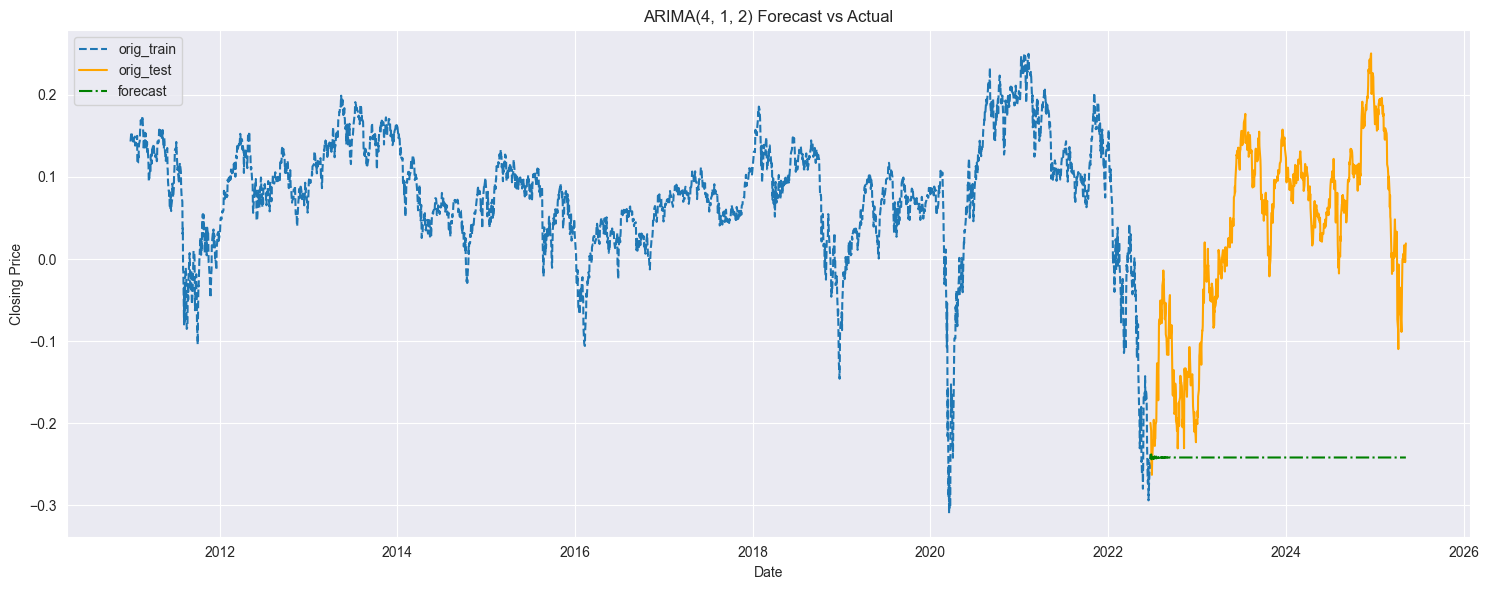

In [27]:
train_index = train.index
test_index = test.index

plt.figure(figsize=(15, 6))
plt.plot(train_index, train, label='orig_train', linestyle='--', color='tab:blue')
plt.plot(test_index, test, label='orig_test', color='orange')
plt.plot(test_index, forecast, label='forecast', linestyle='-.', color='green')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title(f'ARIMA{best_order} Forecast vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

This plot shows the performance of the ARIMA(4,1,2) model on the differenced log-transformed and moving average subtracted closing prices of XLY. The blue dashed line represents the training data, while the orange line shows the actual values in the test set. The green dashed line displays the model’s forecast across the test period. Although the training series appears to exhibit structured fluctuations with identifiable cycles and volatility, the model’s forecast is totally flat. This static behavior suggests that while the model may fit the historical data statistically well, it is unable to adapt to the directional shifts and volatility of the unseen test data. The flat forecast line implies that the model is projecting a mean-reverting or equilibrium state, but in doing so, it underfits the true behavior, failing to capture recent dynamic market movements. This could be due to the differencing step removing too much of the signal, or the ARIMA structure being inherently limited in modeling sharp trend reversals or persistent drift. Overall, while ARIMA(4,1,2) may be well-behaved statistically, its practical utility as a predictive model is constrained in this context unless augmented with external regressors or a more flexible model class.

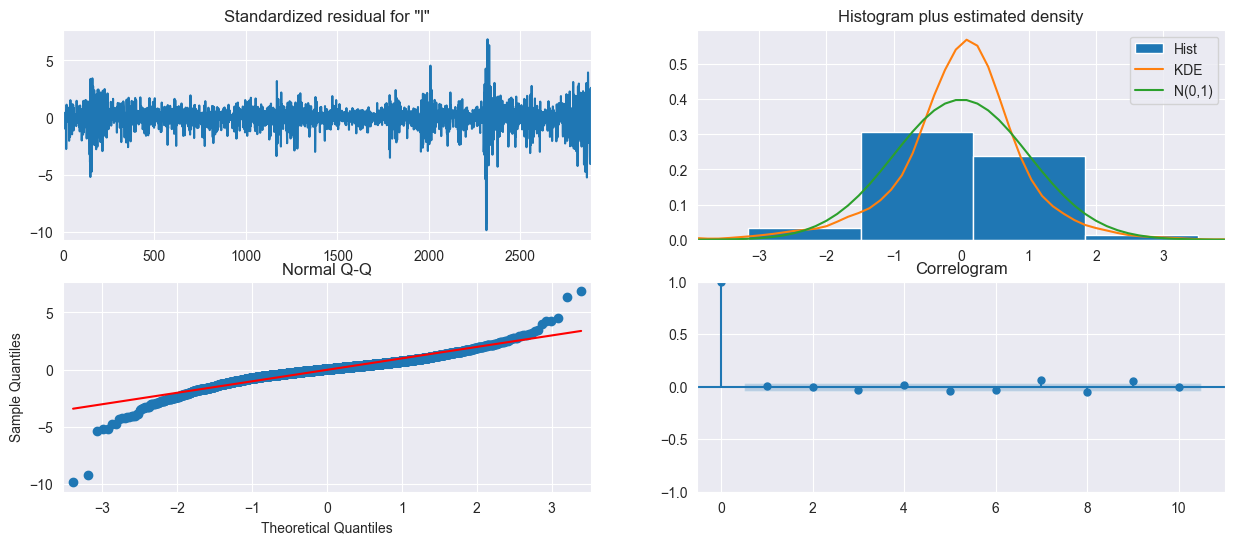

In [28]:
plt.rcParams['figure.figsize'] = [15, 6]
results.plot_diagnostics()
plt.show()

This set of diagnostic plots assesses the validity of the ARIMA(4,1,2) model’s residuals and helps determine whether the model appropriately captured the structure of the data. The top-left panel, which shows standardized residuals over time, suggests that the residuals fluctuate randomly around zero with no clear pattern or time-dependent structure, indicating that the model adequately captured the underlying trend and autocorrelation. The top-right histogram and kernel density estimate (KDE) plot reveal that the residuals are approximately bell-shaped but exhibit slight leptokurtosis and minor left skew, as seen by the KDE diverging from the ideal normal curve (green). The Q-Q plot in the bottom-left panel further confirms this non-normality, with deviations from the red line in both tails indicating that the residuals are not perfectly normally distributed. Lastly, the bottom-right autocorrelation plot shows that most autocorrelation values lie within the 95% confidence bounds, indicating no significant residual autocorrelation. These diagnostics confirm that the ARIMA(4,1,2) model satisfies the assumptions of residual independence and homoscedasticity, although minor deviations from normality remain. This makes the model **statistically** sound, but unreliable for forecasting purposes.

## Predicting the next 90 days

In [29]:
# refit on full data
xly_series = xly_series.dropna()
full_model = ARIMA(xly_series, order=best_order)
full_model_fit = full_model.fit()

In [30]:
n = 90  # days
future_forecast = full_model_fit.forecast(steps=n)

# forecast
forecast_index = pd.date_range(start=xly_series.index[-1] + pd.Timedelta(days=1), periods=n, freq='B')
forecast_series = pd.Series(data=future_forecast, index=forecast_index)

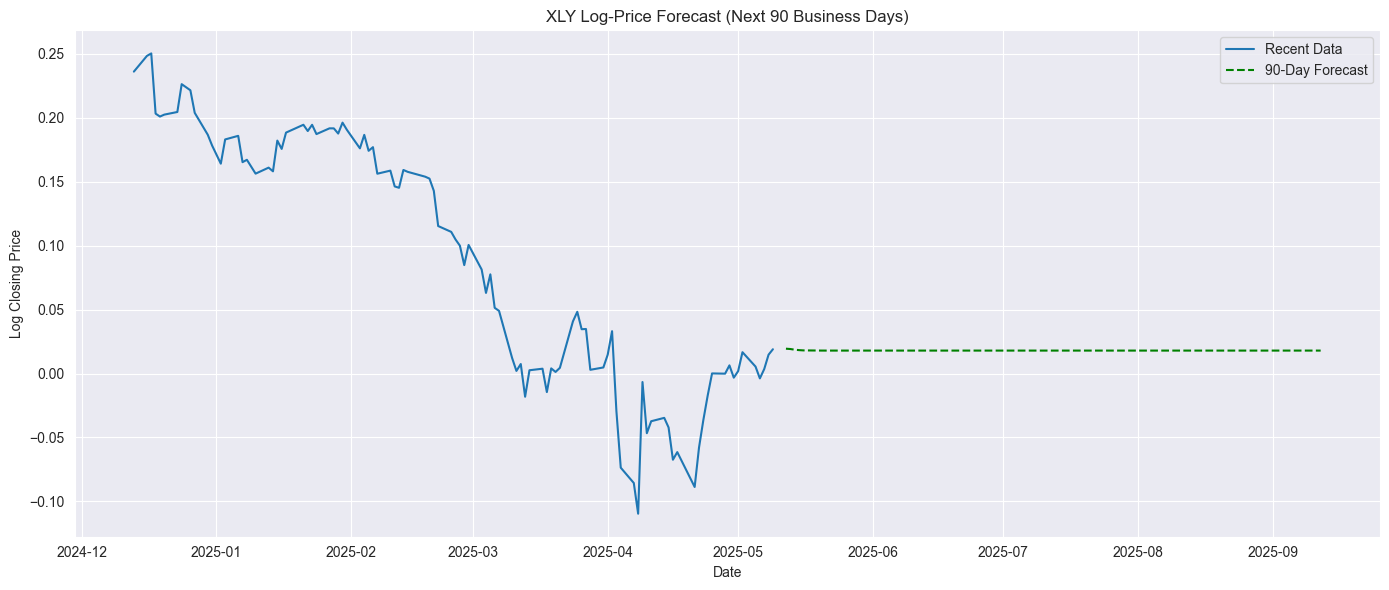

In [31]:
future_forecast.index = forecast_index
forecast_series = future_forecast

plt.figure(figsize=(14,6))
plt.plot(xly_series[-100:], label='Recent Data')
plt.plot(forecast_series.index, forecast_series.values, linestyle='--', color='green', label='90-Day Forecast')
plt.title('XLY Log-Price Forecast (Next 90 Business Days)')
plt.xlabel('Date')
plt.ylabel('Log Closing Price')
plt.legend()
plt.tight_layout()
plt.show()

This chart presents the 90-business-day ahead forecast of the log-transformed and moving average subtracted closing prices of XLY, effectively representing short-term log returns. The solid blue line shows the recent trajectory of returns, capturing substantial volatility with a sharp drop in March–April 2025 followed by a partial recovery. The green dashed line extending forward represents the ARIMA(4,1,2) model's point forecast for future returns. Notably, the forecast is essentially flat, indicating that the model expects the average return to stabilize around zero in the near term. This reflects a common tendency in ARIMA models when applied to stationary return series, as they often default to forecasting the series’ long-run mean when no strong autocorrelation remains. While the model is statistically sound, the result might be exhibiting a limitation of univariate ARIMA in financial forecasting: it cannot capture drift, momentum, or external shocks without additional exogenous variables or model complexity. In practical terms, the model assumes that the recent fluctuations are temporary and that returns will revert to a neutral baseline which is an assumption that should be interpreted cautiously in volatile or non-stationary market environments.

# References:
* Fiveable. (2024, July 23). 3.3 Differencing and transformation techniques – Intro to Time Series. https://library.fiveable.me/intro-time-series/unit-3/differencing-transformation-techniques/study-guide/YPiKne797TvFOxHv
* GeeksforGeeks. (2025, April 28). Understanding the Moving average (MA) in Time Series Data. GeeksforGeeks. https://www.geeksforgeeks.org/understanding-the-moving-average-ma-in-time-series-data/
* GeeksforGeeks. (2023, October 20). Time Series Decomposition techniques. GeeksforGeeks. https://www.geeksforgeeks.org/time-series-decomposition-techniques